# Test energy loss updates

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import arviz

import sys
sys.path.append("../../../../fancy")


from fancy.interfaces.data import Data
from fancy.interfaces.stan import Model
from fancy.analysis import Analysis
from fancy.propagation.energy_loss import EnergyLoss

In [2]:
source_type = "SBG_23"
detector_type = "TA2015"
model_type = "joint"
ptype = "N"
random_seed = 42
gmf = "None"

stan_path = "../../stan/"
source_file = "../../data/sourcedata.h5"
uhecr_file = "../../data/UHECRdata.h5"

output_file = (
    "output/"
    + f"test_{model_type}_fit_{source_type}_{detector_type}_{gmf}_{ptype}_{random_seed}.h5"
)

In [3]:
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, alpha_T, M, Eth
else:
    raise Exception("Unknown detector type!")

Test table calculation

In [4]:
data = Data()
data.add_source(source_file, source_type)  
data.add_detector(detector_properties) 

In [5]:
if model_type == "arrival":
    model_fname = stan_path + "arrival_direction_model.stan"
    summary = b"Fit of the arrival direction model to data"
elif model_type == "joint":
    model_fname = stan_path + "joint_model_tightB.stan"
    summary = b"Fit of the joint model to data"
elif model_type == "joint_gmf":
    model_fname = stan_path + "joint_gmf_model_tightB.stan"
    summary = b"Fit of the joint + GMF model to data"
else:
    raise Exception(f"Undefined model type {model_type}")

model = Model(model_filename=model_fname, include_paths=stan_path)
model.compile()
model.input(Eth=Eth, ptype=ptype)  # EeV

In [6]:
table_file = "output/test_table_{0}_{1}".format(source_type, detector_type)

summary = b'Precomputation for tables'
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = table_file, summary = summary, energy_loss_approx="mean_sim_energy")

print("Evaluating Exposure Integral...")
analysis.build_tables(fit_only = True)
analysis.tables.save(table_file)

print("Evaluating Arrival Energies...")
analysis.build_energy_table(table_file = table_file, parallel=True)

Evaluating Exposure Integral...


Precomputing exposure integral: 100%|██████████| 23/23 [01:19<00:00,  3.46s/it]



Evaluating Arrival Energies...


Precomputing energy grids: 100%|██████████| 23/23 [00:00<00:00, 865.53it/s]


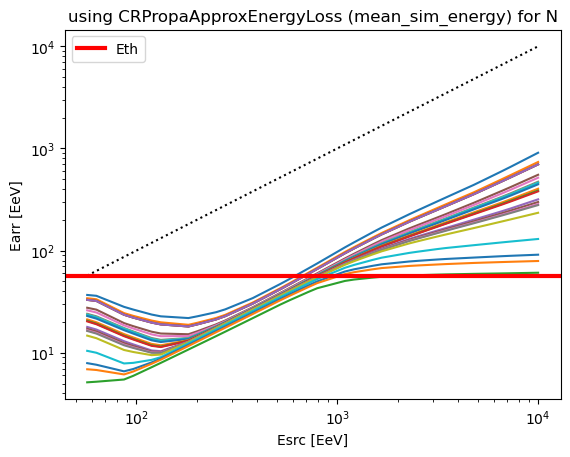

In [7]:
fig, ax = plt.subplots()
for Earr_g in analysis.Earr_grid:
    ax.plot(analysis.E_grid, Earr_g)
ax.plot(analysis.E_grid, analysis.E_grid, color="k", linestyle=":")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Esrc [EeV]")
ax.set_ylabel("Earr [EeV]")
ax.set_title("using CRPropaApproxEnergyLoss (mean_sim_energy) for N")
ax.axhline(Eth, color="red", lw=3, label="Eth")
ax.legend()
fig.savefig("figures/stan_tables_nitrogen_mean_sim_energy.pdf")

Test fit

In [8]:
data = Data()
data.add_source(source_file, source_type)  
data.add_uhecr(uhecr_file, detector_type, ptype=ptype)
data.add_detector(detector_properties) 

model = Model(model_filename=model_fname, include_paths=stan_path)
model.compile()
model.input(Eth=Eth, ptype=ptype)  # EeV

19:53:13 - cmdstanpy - INFO - compiling stan file /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan to exe file /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB
19:53:37 - cmdstanpy - INFO - compiled model executable: /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB
19:53:37 - cmdstanpy - WARNING - Stan compiler has produced 5 warnings:
19:53:37 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan --o=/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.hpp /home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan
Warning in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/uhecr_propagation.stan', line 174, column 23, included from
'/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tigh

In [9]:
analysis = Analysis(
    data,
    model,
    analysis_type=model_type,
    filename=output_file,
    summary=summary,
)

analysis.use_tables(table_file)

# Fit the Stan model
fit = analysis.fit_model(chains=8, iterations=500, seed=random_seed)

# Save to analysis file
analysis.save()

19:57:40 - cmdstanpy - INFO - CmdStan start processing


Performing fitting...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

chain 6 |          | 00:00 Status

chain 7 |          | 00:00 Status

chain 8 |          | 00:00 Status

19:59:24 - cmdstanpy - INFO - CmdStan done processing.
19:59:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: pareto_lpdf: Shape parameter is 0, but must be positive finite! (in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan', line 142, column 1 to column 48)
	Exception: pareto_lpdf: Shape parameter is 0, but must be positive finite! (in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan', line 142, column 1 to column 48)
Exception: pareto_lpdf: Shape parameter is 0, but must be positive finite! (in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan', line 142, column 1 to column 48)
	Exception: pareto_lpdf: Shape parameter is 0, but must be positive finite! (in '/home/iwsatlas1/capel/projects/uhecr_model_ta/uhecr_model/stan/joint_model_tightB.stan', line 142, column 1 to column 48)
Exception: pareto_lpdf: Shape parameter is 0, but must be positive fi


Checking all diagnostics...
Done!


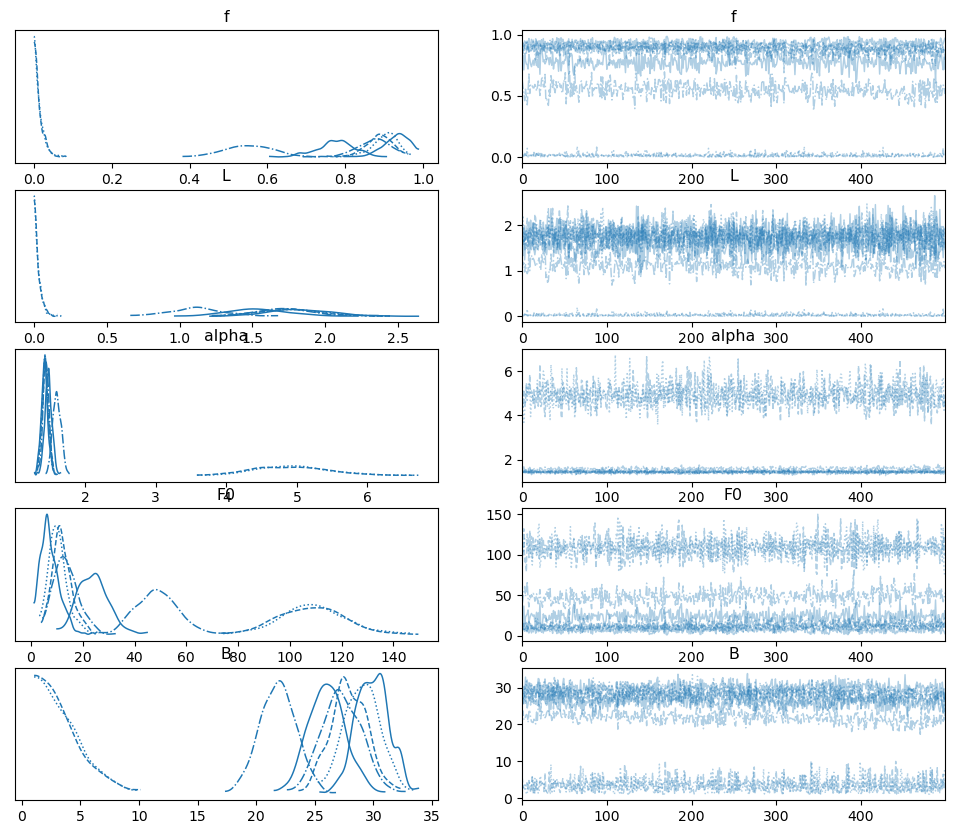

In [13]:
arviz.plot_trace(fit, var_names=["f", "L", "alpha", "F0", "B"]);

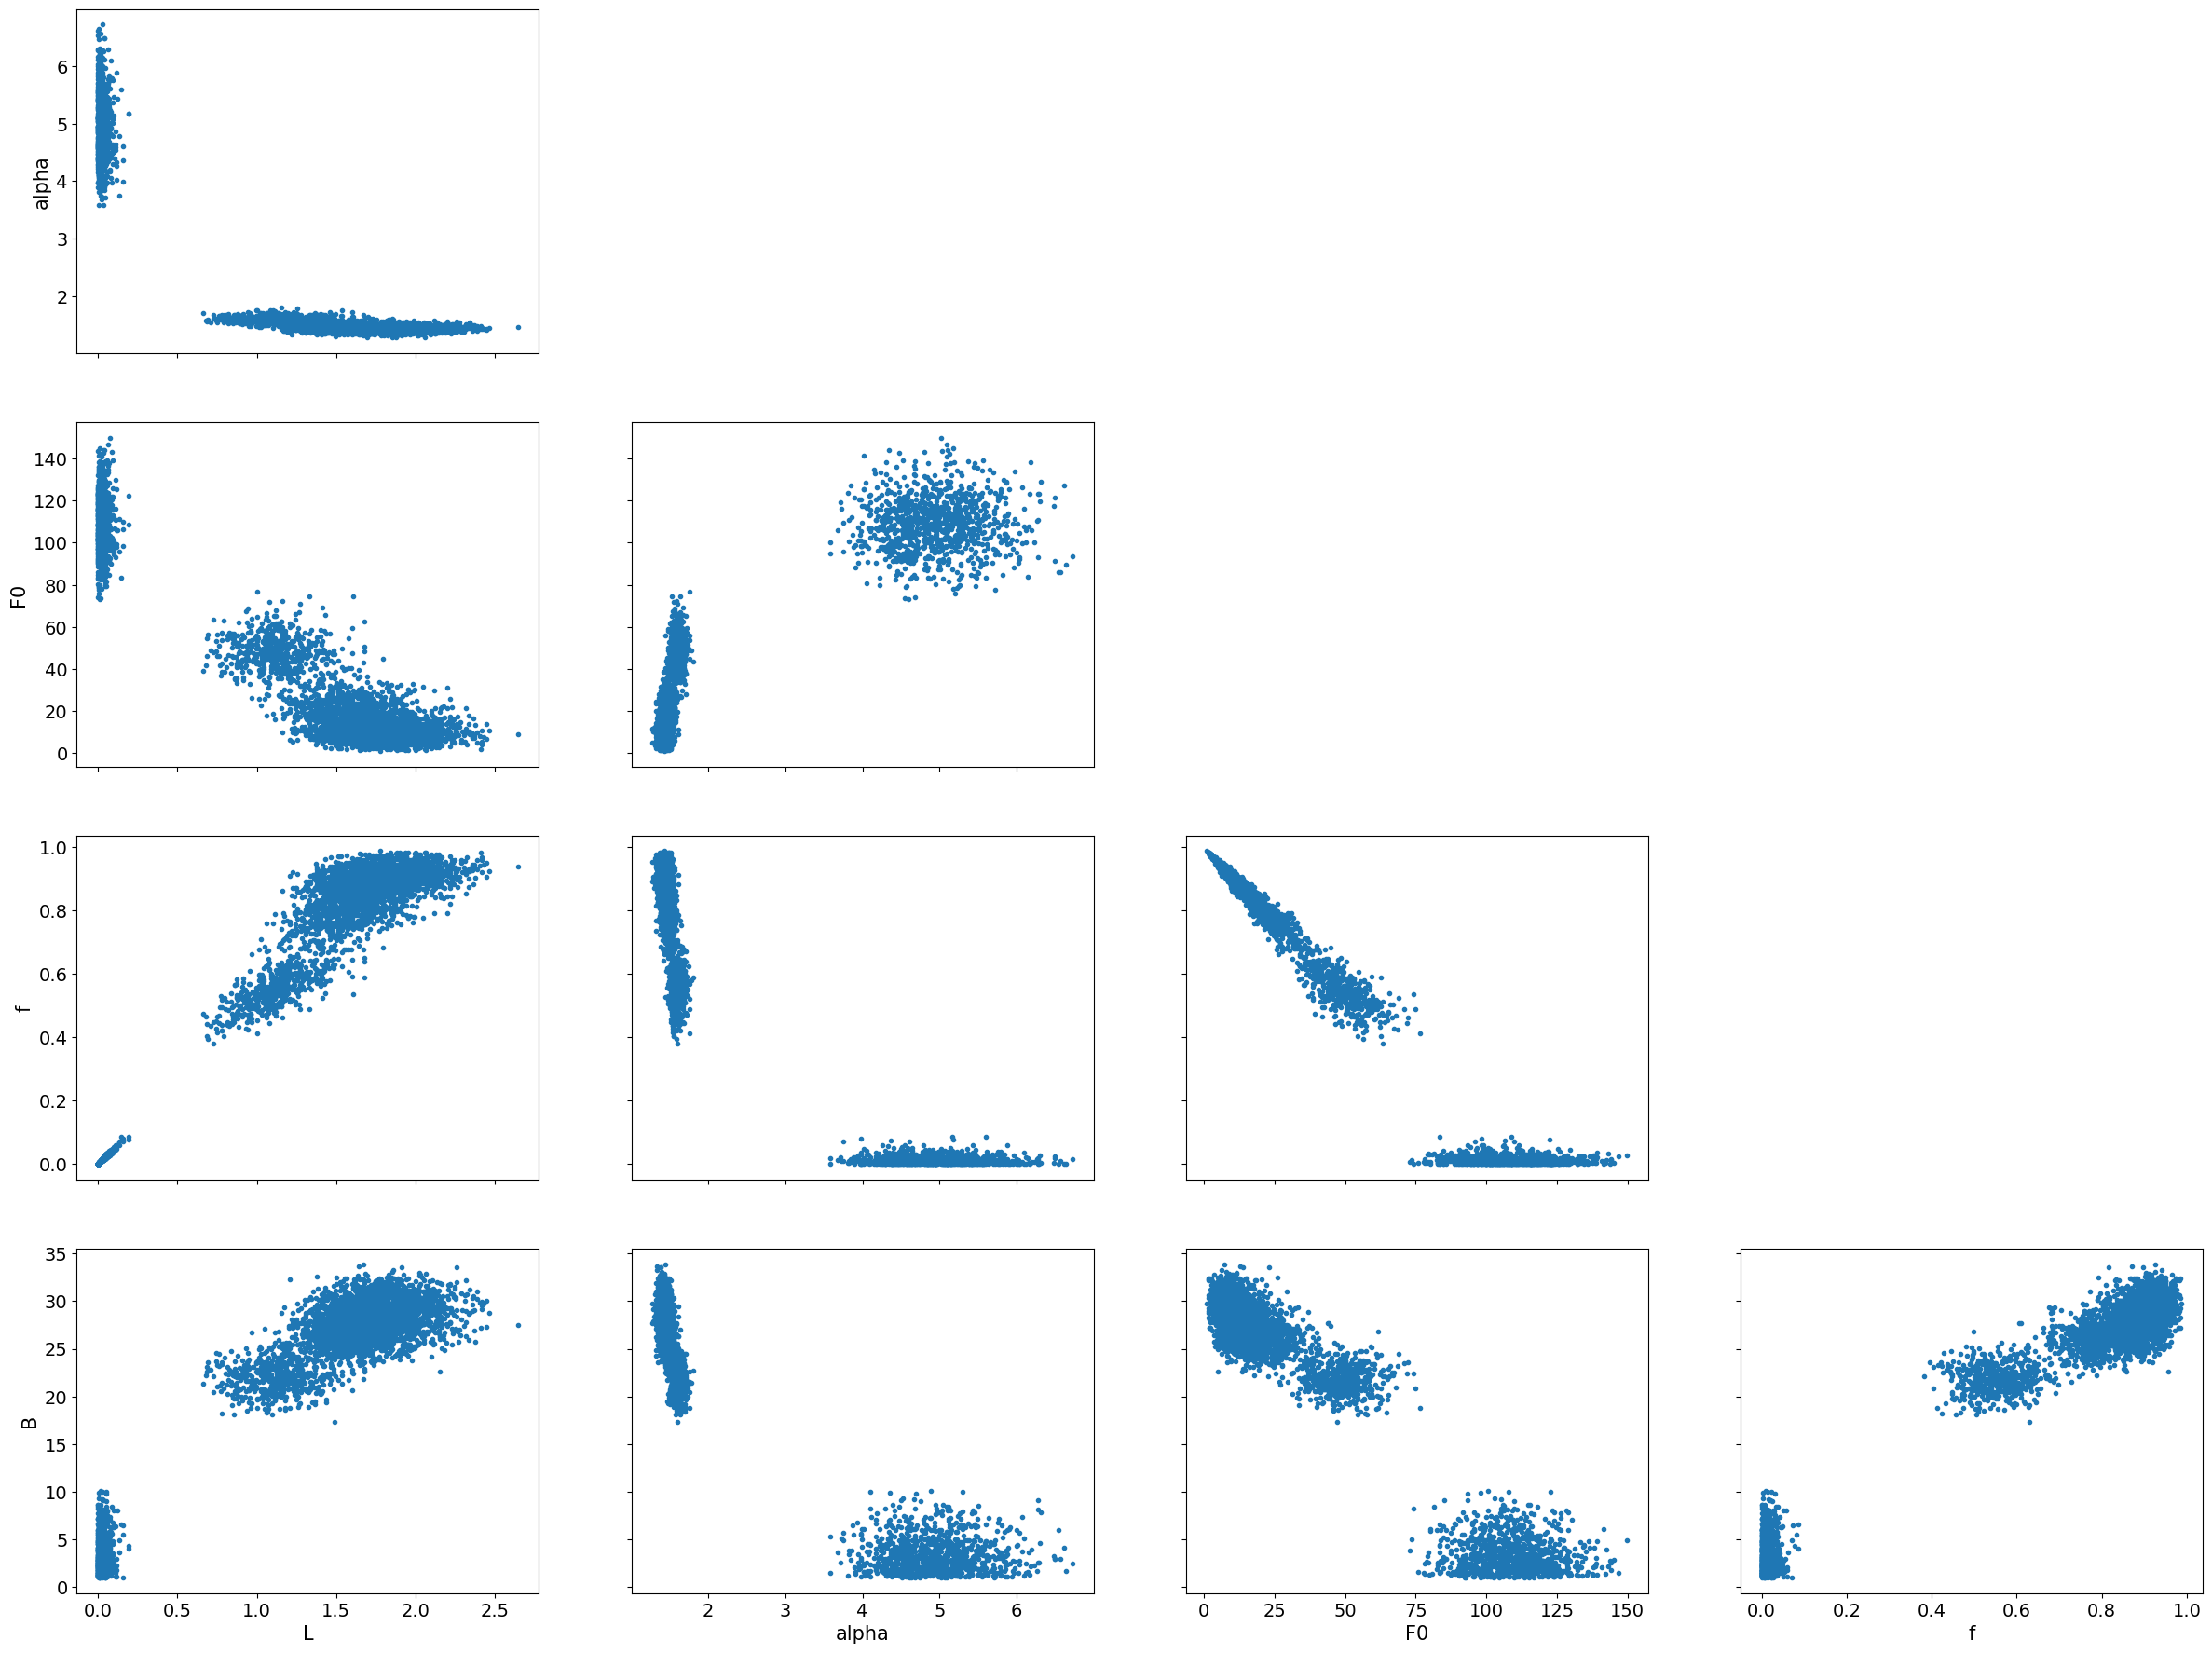

In [14]:
arviz.plot_pair(fit, var_names=["L", "alpha", "F0", "f", "B"]);

Results

In [15]:
from fancy.analysis.results import Results
from fancy.plotting import AllSkyMapCartopy as AllSkyMap
from fancy.interfaces.stan import Direction

In [16]:
results_p = Results("output/test_joint_fit_SBG_23_TA2015_None_p_42.h5")
results_N = Results("output/test_joint_fit_SBG_23_TA2015_None_N_42.h5")

Text(0.5, 0, 'f')

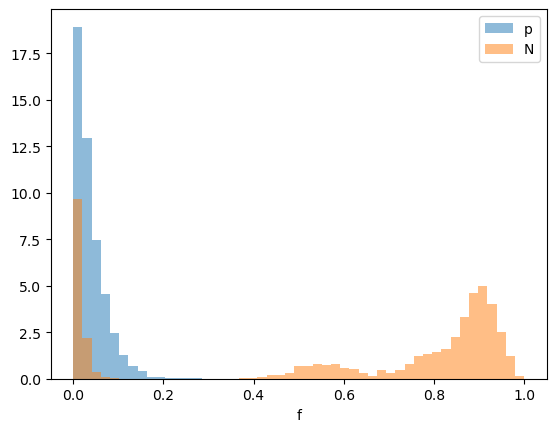

In [17]:
bins = np.linspace(0, 1)

fig, ax = plt.subplots()
ax.hist(results_p.get_chain(["f"])["f"], bins=bins, alpha=0.5, label="p", density=True)
ax.hist(results_N.get_chain(["f"])["f"], bins=bins, alpha=0.5, label="N", density=True)
ax.legend()
ax.set_xlabel("f")
